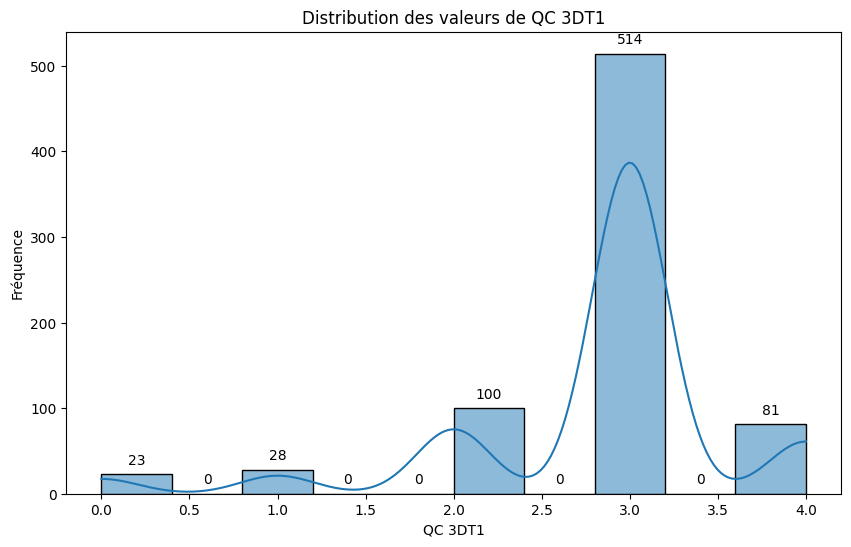

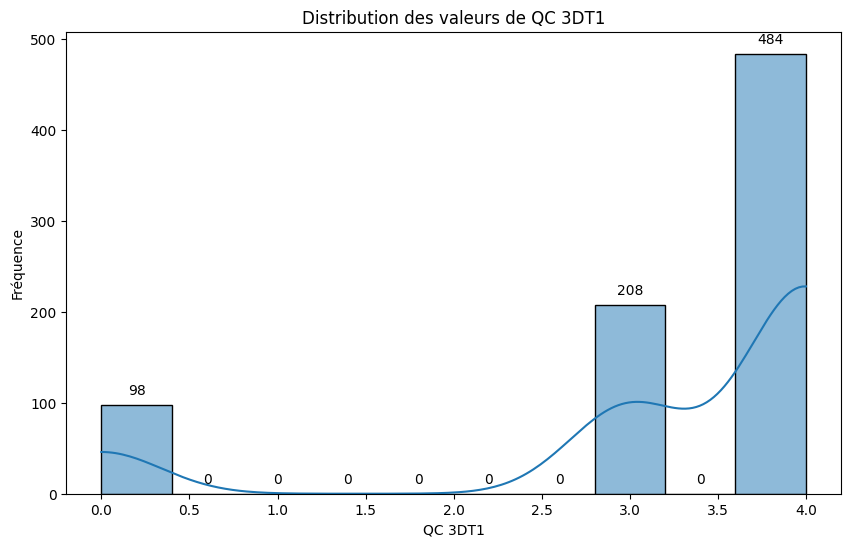

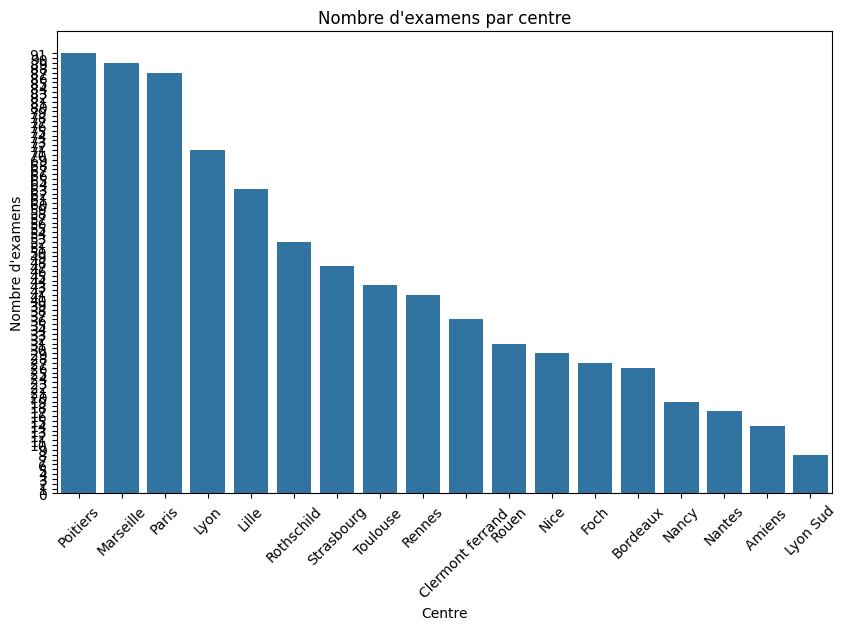

<Figure size 640x480 with 0 Axes>

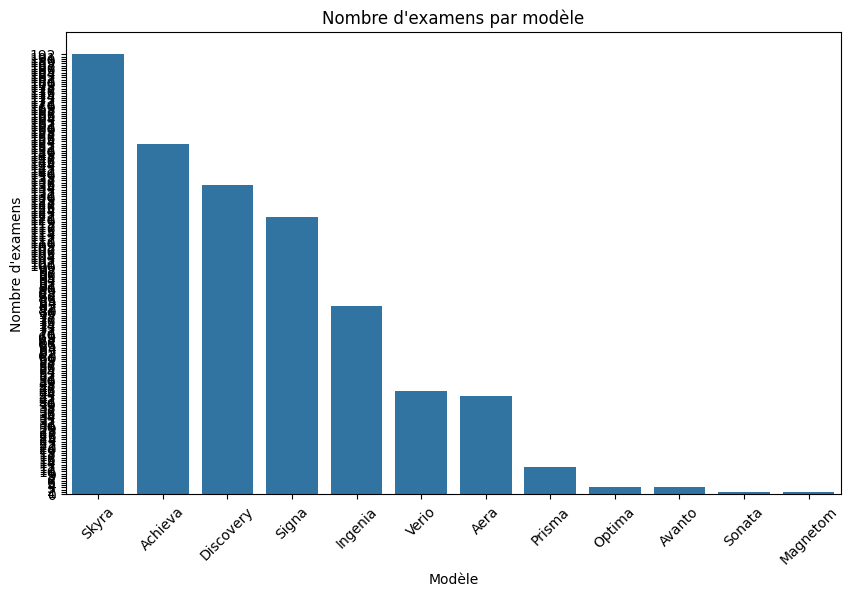

<Figure size 640x480 with 0 Axes>

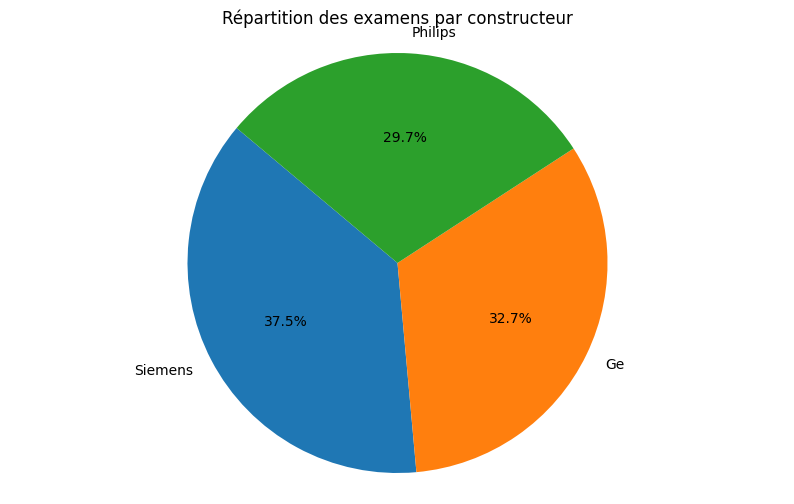

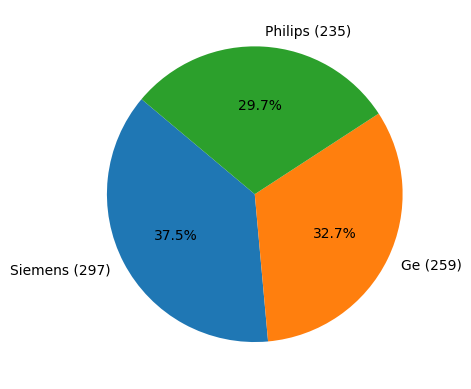

In [2]:
import nibabel as nib
import numpy as np
import os,sys
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression
from scipy import stats
#import plotnine as p9
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import statsmodels.api as sm
#from radiomics import featureextractor, getTestCase
#import SimpleITK as sitk
import import_ipynb
sys.path.append('/home/romain/SVN/python/romain')
from Predistim_Library import *
#import radiomics as rm
from scipy import ndimage
from scipy.ndimage import gaussian_filter

In [3]:
CQData = pd.read_excel(CQ_FILE,index_col=0,engine='openpyxl')
CQData = CQData[CQData.index.notnull()]
CQ_DB=set(CQData.index)

ClinicalData = pd.read_excel(CLI_FILE,index_col=1,engine='openpyxl',converters={'PatientID':str,'PatientNB':str})
ClinicalData = ClinicalData[ClinicalData.index.notnull()]
ClinicalData = ClinicalData[ClinicalData.filter(regex='^(?!Unnamed)').columns]

#ClinicalData = pd.read_excel(CLI_FILE,index_col=1,engine='openpyxl',dtype=str)
#ClinicalData = pd.read_excel(CLI_FILE,index_col=1,engine='openpyxl')

GenomicData = pd.read_excel(SNP_FILE,usecols=('PatientNB','SNP_ACSL4','SNP_GPx4', 'cluster_SNP', 'Selenium', 'Ferritin ', 'GPx ','NFL ', '4HNE ', 'TNFalpha ', 'IL6', 'AlphaSyn ','LEDD_TOT_V0'),index_col=0,engine='openpyxl',converters={'PatientNB':str})
GenomicData = GenomicData[GenomicData.index.notnull()]

Full_DB=set(ClinicalData.set_index(['PatientID']).index)

print(len(CQ_DB | Full_DB))
Full_DB

853


{'01001SR',
 '01002TM',
 '01003SJ',
 '01004DJ',
 '01005LB',
 '01006DF',
 '01007HC',
 '01008GM',
 '01009WF',
 '01010VD',
 '01011BB',
 '01012BB',
 '01013PR',
 '01014DE',
 '01015HC',
 '01016BP',
 '01017TA',
 '01018MT',
 '01019LJ',
 '01020VM',
 '01021CT',
 '01022FZ',
 '01023CF',
 '01024FC',
 '01025RE',
 '01026AF',
 '01027TM',
 '01028SA',
 '01029LL',
 '01030DM',
 '01031FB',
 '01032HM',
 '01033DG',
 '01034UG',
 '01035RM',
 '01036LD',
 '01037DA',
 '01038PG',
 '01039AC',
 '01040LC',
 '01041GR',
 '01042FP',
 '01043GC',
 '01044SD',
 '01045TP',
 '01046AA',
 '01047DM',
 '01048LJ',
 '01049BC',
 '01050ME',
 '01051SJ',
 '01052LD',
 '01053QJ',
 '01054LP',
 '01055WM',
 '01056ND',
 '01057LL',
 '01058LS',
 '01059MV',
 '01060PC',
 '01061CD',
 '01062TP',
 '01063AB',
 '02001VE',
 '02002MS',
 '02003SJ',
 '02004GB',
 '02005MJ',
 '02006DP',
 '02007ST',
 '02008RL',
 '02009LP',
 '02010DP',
 '02011BH',
 '02012HX',
 '02013TD',
 '02014BP',
 '02015DP',
 '02016BZ',
 '02017VL',
 '02018RM',
 '02019GF',
 '02020BD',
 '02

In [4]:
CQData.rename(columns={'décision 3DT1\n':'QC3DT1'},inplace=True)
CQData.rename(columns={'décision 3DMULTI':'QCMultiTE'},inplace=True)

# Afin de voir quels patients sont en +/- dans le dernier envoi du CATI

In [81]:
# Lire les fichiers Excel
file1 = '/NAS/deathrow/protocoles/predistim/csv_xlsx/Predistim_MRIdata_v20200406_update20201204.xlsx'
file2 = '/NAS/deathrow/protocoles/predistim/20241213-143037_3DT1_rsfMRI_DTI_b0map/Predistim_MRIdata_3DT1_rsfMRI_DTI_b0map_13122024_mod.xlsx'

data1 = pd.read_excel(file1, engine='openpyxl')
data2 = pd.read_excel(file2, engine='openpyxl')

# Extraire les colonnes contenant les codes patients
codes1 = set(data1['Code patient'])
codes2 = set(data2[' Code patient'])

# Comparer les codes patients
common_codes = codes1 & codes2
unique_to_file1 = codes1 - codes2
unique_to_file2 = codes2 - codes1

print(f"Nombre de codes communs: {len(common_codes)}")
print(f"Nombre de codes uniques au fichier 1: {len(unique_to_file1)} {unique_to_file1}")
print(f"Nombre de codes uniques au fichier 2: {len(unique_to_file2)} {unique_to_file2}")

Nombre de codes communs: 777
Nombre de codes uniques au fichier 1: 20 {'13035TA', '07007FR', '13014FM', '20021JP', '02022AH', '13047LF', '07010MM', '13023DJ', '13044HC', '07006TM', '13003EJ', '13033KG', '07012BF', '07008PO', '07002PS', '13022KR', '02037CC', '13032PB', '02042AA', '07009BN'}
Nombre de codes uniques au fichier 2: 14 {'09005SF', '17012BF', '09024LC', '11002HD', '17007JY', '09015CA', '09009GM', '01036LD', '09003ME', '09006JY', '09025BJ', '11003DP', '13058WS', '08027BB'}


# Pour les Volumes 

In [4]:
df = pd.DataFrame()

#for ind,SUBJ in enumerate(sorted((CQ_DB | Full_DB) - set(df.index))):
for ind, SUBJ in enumerate(sorted((CQ_DB | Full_DB))):  
    print(SUBJ)
    PARA='3DT1'
    file = os.path.join(STUDY_PATH, 'HCP', SUBJ, 'T1w', SUBJ, 'mri', 'T1FS_resliced.nii.gz')
    if os.path.isfile(file):
        print(file)                
        #img_data = np.asanyarray(nib.load(file).dataobj)  
        #img_data = np.abs(img_data)
        #img_data = gaussian_filter(img_data, sigma=2.548)
        # VOLBRAIN caudé 3/4, Putamen 5/6, thalamus 7/8, Globus pallidus 9/10, hipocampus 11/12, amigdala 13/14
        struct_file = os.path.join(STUDY_PATH, '3DT1', SUBJ, 'native_lab_' + SUBJ + '_resliced.nii.gz')
        print(struct_file)                        
        if os.path.exists(struct_file):
            list_oar = ["Ventricules", "Caudate", "Putamen", "Thalamus", "Globus_pallidus", "Hippocampus", "Amygde"]
            struct = nib.load(struct_file)
            struct_data = np.asanyarray(struct.dataobj, dtype=int)
            voxel_dims = (struct.header["pixdim"])[1] * (struct.header["pixdim"])[2] * (struct.header["pixdim"])[3]
            for cpt1, cpt2, name_struct in zip(np.arange(1, 16, 2), np.arange(2, 17, 2), list_oar):
                df.loc[SUBJ, PARA + "_volume_" + name_struct+"_L"] = np.sum(struct_data == cpt1) * voxel_dims
                df.loc[SUBJ, PARA + "_volume_" + name_struct+"_R"] = np.sum(struct_data == cpt2) * voxel_dims

        else:
            print("Pas de volbrain pour ", SUBJ)
    
        # FREESURFER cingulaireAnterieure 1002&1026/2002&2026 superieurFrontal 1028/2028    
        # struct_file = os.path.join(STUDY_PATH, '3DT1', SUBJ, 'aparc+aseg_resliced.nii.gz')
        struct_file = os.path.join(STUDY_PATH, 'HCP', SUBJ, 'T1w', SUBJ, 'mri', 'aparc+aseg_resliced.nii.gz')
        # print(struct_file)
        if os.path.exists(struct_file): 
            struct = nib.load(struct_file)
            struct_data = np.asanyarray(struct.dataobj)   
            voxel_dims = (struct.header["pixdim"])[1] * (struct.header["pixdim"])[2] * (struct.header["pixdim"])[3]                            
            df.loc[SUBJ, PARA + "_volume_Insula_L"] = np.sum(struct_data == 19) * voxel_dims
            df.loc[SUBJ, PARA + "_volume_Insula_R"] = np.sum(struct_data == 55) * voxel_dims

        else:
            print("Pas de freesurfer pour", SUBJ)
    
        # print("ATLAS_GPe_GPi_STh_STR_RN_SN")
        for cpt2, name_struct in enumerate(['FLASH_RN', 'FLASH_SN', 'QSM_GPe', 'QSM_GPi', 'FLASH_STh', 'MP2RAGE_STR']):
            struct_file_L = os.path.join(STUDY_PATH, '3DT1', SUBJ, name_struct + '_L_' + SUBJ + '_on3DT1.nii.gz')
            struct_file_R = os.path.join(STUDY_PATH, '3DT1', SUBJ, name_struct + '_R_' + SUBJ + '_on3DT1.nii.gz')
            if os.path.exists(struct_file_L) and os.path.exists(struct_file_R): 
                struct_L_ = nib.load(struct_file_L)
                struct_R_ = nib.load(struct_file_R)
                #struct_data = np.asanyarray(struct_R_.dataobj) + np.asanyarray(struct_L_.dataobj)
                voxel_dims = (struct_R_.header["pixdim"])[1] * (struct_R_.header["pixdim"])[2] * (struct_R_.header["pixdim"])[3]
                tmp = (struct_data > 0.5)
                df.loc[SUBJ, PARA + "_volume_" + name_struct+"_L"] = np.sum(struct_L_.get_fdata() > 0.5) * voxel_dims
                df.loc[SUBJ, PARA + "_volume_" + name_struct+"_R"] = np.sum(struct_R_.get_fdata() > 0.5) * voxel_dims
            else:
                print("Pas d'atlas pour", SUBJ, struct_file_L, struct_file_R)

01001SR
/NAS/deathrow/protocoles/predistim/HCP/01001SR/T1w/01001SR/mri/T1FS_resliced.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01001SR/native_lab_01001SR_resliced.nii.gz
01002TM
/NAS/deathrow/protocoles/predistim/HCP/01002TM/T1w/01002TM/mri/T1FS_resliced.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01002TM/native_lab_01002TM_resliced.nii.gz
01003SJ
01004DJ
/NAS/deathrow/protocoles/predistim/HCP/01004DJ/T1w/01004DJ/mri/T1FS_resliced.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01004DJ/native_lab_01004DJ_resliced.nii.gz
01005LB
/NAS/deathrow/protocoles/predistim/HCP/01005LB/T1w/01005LB/mri/T1FS_resliced.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01005LB/native_lab_01005LB_resliced.nii.gz
01006DF
/NAS/deathrow/protocoles/predistim/HCP/01006DF/T1w/01006DF/mri/T1FS_resliced.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01006DF/native_lab_01006DF_resliced.nii.gz
01007HC
/NAS/deathrow/protocoles/predistim/HCP/01007HC/T1w/01007HC/mri/T1FS_resliced.nii.gz
/NAS/deathrow/protocoles/

In [ ]:
df.to_csv(os.path.join(STUDY_PATH,'20250303_3DT1_Volumes.csv'))
df.to_excel(os.path.join(STUDY_PATH,'20250303_3DT1_Volumes.xlsx'))

# Pour les R2*

In [14]:
#df = pd.DataFrame()

for ind,SUBJ in enumerate(sorted((CQ_DB | Full_DB) - set(df.index))):
#for ind, SUBJ in enumerate(sorted((CQ_DB | Full_DB))):  
    print(SUBJ)
    PARA='R2'
    file=os.path.join(STUDY_PATH,PARA,SUBJ,PARA+'_lin_3DT1.nii.gz')  
    if (os.path.isfile(file)) :
        img_data=np.asanyarray(nib.load(file).dataobj)
        struct_file = os.path.join(STUDY_PATH, '3DT1', SUBJ, 'native_lab_' + SUBJ + '_resliced.nii.gz')
        print(struct_file)                        
        if os.path.exists(struct_file):
            list_oar = ["Ventricules", "Caudate", "Putamen", "Thalamus", "Globus_pallidus", "Hippocampus", "Amygdale"]
            struct = nib.load(struct_file)
            struct_data = np.asanyarray(struct.dataobj, dtype=int)
            if img_data.shape != struct_data.shape:
                print(f"Les dimensions de img_data  {file} et struct_data {struct_file} ne correspondent pas pour {SUBJ}")
            else :
                for cpt1, cpt2, name_struct in zip(np.arange(1, 16, 2), np.arange(2, 17, 2), list_oar):
                    df.loc[SUBJ, PARA + "_mean_" + name_struct+"_L"] = np.mean(img_data[struct_data == cpt1])
                    df.loc[SUBJ, PARA + "_mean_" + name_struct+"_R"] = np.mean(img_data[struct_data == cpt2])
        else:
            print("Pas de volbrain pour ", SUBJ)

        # FREESURFER cingulaireAnterieure 1002&1026/2002&2026 superieurFrontal 1028/2028    
        # struct_file = os.path.join(STUDY_PATH, '3DT1', SUBJ, 'aparc+aseg_resliced.nii.gz')
        struct_file = os.path.join(STUDY_PATH, 'HCP', SUBJ, 'T1w', SUBJ, 'mri', 'aparc+aseg_resliced.nii.gz')
        # print(struct_file)
        if os.path.exists(struct_file): 
            struct = nib.load(struct_file)
            struct_data = np.asanyarray(struct.dataobj)  
            if img_data.shape != struct_data.shape:
                print(f"Les dimensions de img_data  {file} et struct_data {struct_file} ne correspondent pas pour {SUBJ}")
            else : 
                df.loc[SUBJ, PARA + "_mean_Insula_L"] = np.mean(img_data[struct_data == 19])
                df.loc[SUBJ, PARA + "_mean_Insula_R"] = np.mean(img_data[struct_data == 55]) 
        else:
            print("Pas de freesurfer pour", SUBJ)

        # print("ATLAS_GPe_GPi_STh_STR_RN_SN")
        for cpt2, name_struct in enumerate(['FLASH_RN', 'FLASH_SN', 'QSM_GPe', 'QSM_GPi', 'FLASH_STh', 'MP2RAGE_STR']):
            struct_file_L = os.path.join(STUDY_PATH, '3DT1', SUBJ, name_struct + '_L_' + SUBJ + '_on3DT1.nii.gz')
            struct_file_R = os.path.join(STUDY_PATH, '3DT1', SUBJ, name_struct + '_R_' + SUBJ + '_on3DT1.nii.gz')
            if os.path.exists(struct_file_L) and os.path.exists(struct_file_R): 
                struct_L_ = nib.load(struct_file_L)
                struct_R_ = nib.load(struct_file_R)
                if img_data.shape != struct_data.shape:
                    print(f"Les dimensions de img_data {file} et struct_data {struct_file_L} {struct_file_R} ne correspondent pas pour {SUBJ}")
                else :
                    df.loc[SUBJ, PARA + "_mean_" + name_struct+"_L"] = np.mean(img_data[struct_L_.get_fdata() > 0.5])
                    df.loc[SUBJ, PARA + "_mean_" + name_struct+"_R"] = np.mean(img_data[struct_R_.get_fdata() > 0.5])
            else:
                print("Pas d'atlas pour", SUBJ, struct_file_L, struct_file_R)


01001SR
01002TM
01003SJ
01004DJ
01005LB
01006DF
01007HC
01008GM
01009WF
01010VD
01012BB
01013PR
01021CT
01022FZ
01032HM
01033DG
01036LD
01041GR
01042FP
01043GC
01047DM
01049BC
01051SJ
01052LD
01053QJ
01054LP
01055WM
01056ND
01057LL
01058LS
01062TP
01063AB
02001VE
02002MS
02005MJ
02008RL
02010DP
02013TD
02016BZ
02019GF
02022AH
02023BB
02026LJ
02031BO
02032DI
02033PP
02035NA
02037CC
02039CJ
02042AA
02043GA
02044LC
02045PJ
02047MA
02048LN
02049AT
02050RF
02051GB
02052DP
02055BV
02056QB
02057DH
02058NP
02060AR
02061SA
02062XA
02066RM
02072MN
02073MD
02074AS
02075LP
02076LM
02077VD
02080RM
02082SR
02083SG
02086YT
02088AH
02090DA
04001FP
04002OC
04003MG
04004KN
04005BV
04006CB
04007GA
04008QM
04009HM
04010BC
04011JM
04012CD
04013GJ
04014MY
04015MP
04016RA
04017CF
05001GR
05004BC
05005TL
05006BC
05007PM
05008DM
05021LR
05025DB
05026NM
05029FB
05037PC
06002AM
06017PD
06020MB
06035PD
06059GD
06063GJ
06069ER
06074WA
06077DR
06084LC
06088FP
07001DM
07002PS
07003PR
07004PJ
07005BC
07006TM
07007FR


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07016ME
/NAS/deathrow/protocoles/predistim/3DT1/07016ME/native_lab_07016ME_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07017LA
07018MD
/NAS/deathrow/protocoles/predistim/3DT1/07018MD/native_lab_07018MD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07019VJ
/NAS/deathrow/protocoles/predistim/3DT1/07019VJ/native_lab_07019VJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07020NJ
/NAS/deathrow/protocoles/predistim/3DT1/07020NJ/native_lab_07020NJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07021FC
/NAS/deathrow/protocoles/predistim/3DT1/07021FC/native_lab_07021FC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07022MB
/NAS/deathrow/protocoles/predistim/3DT1/07022MB/native_lab_07022MB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07023LG
/NAS/deathrow/protocoles/predistim/3DT1/07023LG/native_lab_07023LG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07024CP
/NAS/deathrow/protocoles/predistim/3DT1/07024CP/native_lab_07024CP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07025MS
/NAS/deathrow/protocoles/predistim/3DT1/07025MS/native_lab_07025MS_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07026BP
07027BJ
/NAS/deathrow/protocoles/predistim/3DT1/07027BJ/native_lab_07027BJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07028CJ
/NAS/deathrow/protocoles/predistim/3DT1/07028CJ/native_lab_07028CJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07029SD
/NAS/deathrow/protocoles/predistim/3DT1/07029SD/native_lab_07029SD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07030LG
/NAS/deathrow/protocoles/predistim/3DT1/07030LG/native_lab_07030LG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07031DA
07032LJ
07033QJ
07034HC
07035D
07035ND
/NAS/deathrow/protocoles/predistim/3DT1/07035ND/native_lab_07035ND_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07036PJ
/NAS/deathrow/protocoles/predistim/3DT1/07036PJ/native_lab_07036PJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07037HM
/NAS/deathrow/protocoles/predistim/3DT1/07037HM/native_lab_07037HM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07038CF
/NAS/deathrow/protocoles/predistim/3DT1/07038CF/native_lab_07038CF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07039FJ
/NAS/deathrow/protocoles/predistim/3DT1/07039FJ/native_lab_07039FJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07040PP
/NAS/deathrow/protocoles/predistim/3DT1/07040PP/native_lab_07040PP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07041GA
07042DF
/NAS/deathrow/protocoles/predistim/3DT1/07042DF/native_lab_07042DF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07043BN
07044CP
/NAS/deathrow/protocoles/predistim/3DT1/07044CP/native_lab_07044CP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07045PB
/NAS/deathrow/protocoles/predistim/3DT1/07045PB/native_lab_07045PB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07046PF
/NAS/deathrow/protocoles/predistim/3DT1/07046PF/native_lab_07046PF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07047LJ
/NAS/deathrow/protocoles/predistim/3DT1/07047LJ/native_lab_07047LJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07048NC
/NAS/deathrow/protocoles/predistim/3DT1/07048NC/native_lab_07048NC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07049EP
/NAS/deathrow/protocoles/predistim/3DT1/07049EP/native_lab_07049EP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07050GE
/NAS/deathrow/protocoles/predistim/3DT1/07050GE/native_lab_07050GE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07051MC
/NAS/deathrow/protocoles/predistim/3DT1/07051MC/native_lab_07051MC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07052LF
07053LJ
/NAS/deathrow/protocoles/predistim/3DT1/07053LJ/native_lab_07053LJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07054PD
/NAS/deathrow/protocoles/predistim/3DT1/07054PD/native_lab_07054PD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07055BC
/NAS/deathrow/protocoles/predistim/3DT1/07055BC/native_lab_07055BC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07056DB
/NAS/deathrow/protocoles/predistim/3DT1/07056DB/native_lab_07056DB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07057SB
/NAS/deathrow/protocoles/predistim/3DT1/07057SB/native_lab_07057SB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07058PP
/NAS/deathrow/protocoles/predistim/3DT1/07058PP/native_lab_07058PP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07059AR
/NAS/deathrow/protocoles/predistim/3DT1/07059AR/native_lab_07059AR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07060BM
07061CE
07062GC
/NAS/deathrow/protocoles/predistim/3DT1/07062GC/native_lab_07062GC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07063TE
/NAS/deathrow/protocoles/predistim/3DT1/07063TE/native_lab_07063TE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07064SM
/NAS/deathrow/protocoles/predistim/3DT1/07064SM/native_lab_07064SM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07065CD
/NAS/deathrow/protocoles/predistim/3DT1/07065CD/native_lab_07065CD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07066JJ
/NAS/deathrow/protocoles/predistim/3DT1/07066JJ/native_lab_07066JJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07067UJ
/NAS/deathrow/protocoles/predistim/3DT1/07067UJ/native_lab_07067UJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07068DM
/NAS/deathrow/protocoles/predistim/3DT1/07068DM/native_lab_07068DM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07069FM
/NAS/deathrow/protocoles/predistim/3DT1/07069FM/native_lab_07069FM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07070MJ
07071CJ
/NAS/deathrow/protocoles/predistim/3DT1/07071CJ/native_lab_07071CJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07072NJ
/NAS/deathrow/protocoles/predistim/3DT1/07072NJ/native_lab_07072NJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07073FE
/NAS/deathrow/protocoles/predistim/3DT1/07073FE/native_lab_07073FE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07074TB
/NAS/deathrow/protocoles/predistim/3DT1/07074TB/native_lab_07074TB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07075BB
07076MJ
07077AG
/NAS/deathrow/protocoles/predistim/3DT1/07077AG/native_lab_07077AG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07078MA
07079FE
07080OP
07081LC
/NAS/deathrow/protocoles/predistim/3DT1/07081LC/native_lab_07081LC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07082LL
/NAS/deathrow/protocoles/predistim/3DT1/07082LL/native_lab_07082LL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07083FM
/NAS/deathrow/protocoles/predistim/3DT1/07083FM/native_lab_07083FM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07084BJ
07085DP
/NAS/deathrow/protocoles/predistim/3DT1/07085DP/native_lab_07085DP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07085LJ
07086DP
07086LJ
07087CD
/NAS/deathrow/protocoles/predistim/3DT1/07087CD/native_lab_07087CD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07088AJ
/NAS/deathrow/protocoles/predistim/3DT1/07088AJ/native_lab_07088AJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07089TJ
07090RV
/NAS/deathrow/protocoles/predistim/3DT1/07090RV/native_lab_07090RV_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07091MC
/NAS/deathrow/protocoles/predistim/3DT1/07091MC/native_lab_07091MC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07092DH
/NAS/deathrow/protocoles/predistim/3DT1/07092DH/native_lab_07092DH_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07093GP
/NAS/deathrow/protocoles/predistim/3DT1/07093GP/native_lab_07093GP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07094MC
/NAS/deathrow/protocoles/predistim/3DT1/07094MC/native_lab_07094MC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07095BR
/NAS/deathrow/protocoles/predistim/3DT1/07095BR/native_lab_07095BR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07096TC
/NAS/deathrow/protocoles/predistim/3DT1/07096TC/native_lab_07096TC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07097BJ
/NAS/deathrow/protocoles/predistim/3DT1/07097BJ/native_lab_07097BJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07098CA
/NAS/deathrow/protocoles/predistim/3DT1/07098CA/native_lab_07098CA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


07099AH
/NAS/deathrow/protocoles/predistim/3DT1/07099AH/native_lab_07099AH_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08001PV
/NAS/deathrow/protocoles/predistim/3DT1/08001PV/native_lab_08001PV_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08002AS
08003LC
/NAS/deathrow/protocoles/predistim/3DT1/08003LC/native_lab_08003LC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08004PY
/NAS/deathrow/protocoles/predistim/3DT1/08004PY/native_lab_08004PY_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08005DY
/NAS/deathrow/protocoles/predistim/3DT1/08005DY/native_lab_08005DY_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08006SC
/NAS/deathrow/protocoles/predistim/3DT1/08006SC/native_lab_08006SC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08007LV
/NAS/deathrow/protocoles/predistim/3DT1/08007LV/native_lab_08007LV_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08008AF
/NAS/deathrow/protocoles/predistim/3DT1/08008AF/native_lab_08008AF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08009BC
/NAS/deathrow/protocoles/predistim/3DT1/08009BC/native_lab_08009BC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08010SF
/NAS/deathrow/protocoles/predistim/3DT1/08010SF/native_lab_08010SF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08011LH
/NAS/deathrow/protocoles/predistim/3DT1/08011LH/native_lab_08011LH_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08012SF
/NAS/deathrow/protocoles/predistim/3DT1/08012SF/native_lab_08012SF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08013CN
/NAS/deathrow/protocoles/predistim/3DT1/08013CN/native_lab_08013CN_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08014LX
/NAS/deathrow/protocoles/predistim/3DT1/08014LX/native_lab_08014LX_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08015LR
08016HA
/NAS/deathrow/protocoles/predistim/3DT1/08016HA/native_lab_08016HA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08017DV
/NAS/deathrow/protocoles/predistim/3DT1/08017DV/native_lab_08017DV_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08018JC
08019HG
/NAS/deathrow/protocoles/predistim/3DT1/08019HG/native_lab_08019HG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08020VJ
/NAS/deathrow/protocoles/predistim/3DT1/08020VJ/native_lab_08020VJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


08021MM
08022CM
/NAS/deathrow/protocoles/predistim/3DT1/08022CM/native_lab_08022CM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08023LJ
/NAS/deathrow/protocoles/predistim/3DT1/08023LJ/native_lab_08023LJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08024BS
/NAS/deathrow/protocoles/predistim/3DT1/08024BS/native_lab_08024BS_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08025HV
08026FE
08027BB
08028BC
/NAS/deathrow/protocoles/predistim/3DT1/08028BC/native_lab_08028BC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08029JD
08030FS
/NAS/deathrow/protocoles/predistim/3DT1/08030FS/native_lab_08030FS_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08031GD
/NAS/deathrow/protocoles/predistim/3DT1/08031GD/native_lab_08031GD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08032LJ
/NAS/deathrow/protocoles/predistim/3DT1/08032LJ/native_lab_08032LJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08033MA
/NAS/deathrow/protocoles/predistim/3DT1/08033MA/native_lab_08033MA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08034CC
/NAS/deathrow/protocoles/predistim/3DT1/08034CC/native_lab_08034CC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08035LM
/NAS/deathrow/protocoles/predistim/3DT1/08035LM/native_lab_08035LM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08036GE
/NAS/deathrow/protocoles/predistim/3DT1/08036GE/native_lab_08036GE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


08037CG
08038FS
08039PD
08040AC
08041BJ
08042LS
09001MA
/NAS/deathrow/protocoles/predistim/3DT1/09001MA/native_lab_09001MA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09002JN
/NAS/deathrow/protocoles/predistim/3DT1/09002JN/native_lab_09002JN_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09002NJ
09003ME
09004DC
09005SF
09005SN
09006JY
09007GD
/NAS/deathrow/protocoles/predistim/3DT1/09007GD/native_lab_09007GD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09008BF
/NAS/deathrow/protocoles/predistim/3DT1/09008BF/native_lab_09008BF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09009GM
09010NL
/NAS/deathrow/protocoles/predistim/3DT1/09010NL/native_lab_09010NL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09011RY
/NAS/deathrow/protocoles/predistim/3DT1/09011RY/native_lab_09011RY_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09012MF
/NAS/deathrow/protocoles/predistim/3DT1/09012MF/native_lab_09012MF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09013DS
09014BM
09015CA
09016JD
/NAS/deathrow/protocoles/predistim/3DT1/09016JD/native_lab_09016JD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09017CC
/NAS/deathrow/protocoles/predistim/3DT1/09017CC/native_lab_09017CC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09018CT
/NAS/deathrow/protocoles/predistim/3DT1/09018CT/native_lab_09018CT_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09019CA
09020ZM
/NAS/deathrow/protocoles/predistim/3DT1/09020ZM/native_lab_09020ZM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09021PI
/NAS/deathrow/protocoles/predistim/3DT1/09021PI/native_lab_09021PI_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


09022VC
09023CM
09024LC
09025BJ
09026PF
10001HG
10003SF
10004MM
10005LM
10006AP
10007GP
10008GF
10009GR
10010VE
10011TP
10012AG
10013MH
10014PP
10015BF
10016SM
10017BD
10018GA
10019RD
10020NJ
10021SM
10022CD
10023MM
10024BS
10025CM
10026GM
10027IM
10028GJ
10029CM
10030BJ
10031DJ
10032AM
10033OB
10034BJ
10035MP
10036FM
10036LJ
10037FM
10037LJ
10038CD
10039BG
10040EG
10041AF
10042BB
10043MV
10044HF
11002HD
11003DM
11003DP
11005DJ
11006VF
11007DP
11008LC
/NAS/deathrow/protocoles/predistim/3DT1/11008LC/native_lab_11008LC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11009PG
/NAS/deathrow/protocoles/predistim/3DT1/11009PG/native_lab_11009PG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11010LM
11011GM
/NAS/deathrow/protocoles/predistim/3DT1/11011GM/native_lab_11011GM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11012RM
/NAS/deathrow/protocoles/predistim/3DT1/11012RM/native_lab_11012RM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11013GC
/NAS/deathrow/protocoles/predistim/3DT1/11013GC/native_lab_11013GC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11014FM
/NAS/deathrow/protocoles/predistim/3DT1/11014FM/native_lab_11014FM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11015DD
11016SB
/NAS/deathrow/protocoles/predistim/3DT1/11016SB/native_lab_11016SB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11017PT
/NAS/deathrow/protocoles/predistim/3DT1/11017PT/native_lab_11017PT_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11018CP
/NAS/deathrow/protocoles/predistim/3DT1/11018CP/native_lab_11018CP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11019AF
/NAS/deathrow/protocoles/predistim/3DT1/11019AF/native_lab_11019AF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11020DM
/NAS/deathrow/protocoles/predistim/3DT1/11020DM/native_lab_11020DM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11021HM
11022MA
11023OF
/NAS/deathrow/protocoles/predistim/3DT1/11023OF/native_lab_11023OF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11024FJ
/NAS/deathrow/protocoles/predistim/3DT1/11024FJ/native_lab_11024FJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11025PC
/NAS/deathrow/protocoles/predistim/3DT1/11025PC/native_lab_11025PC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11026LE
/NAS/deathrow/protocoles/predistim/3DT1/11026LE/native_lab_11026LE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11027LM
/NAS/deathrow/protocoles/predistim/3DT1/11027LM/native_lab_11027LM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11028BA
/NAS/deathrow/protocoles/predistim/3DT1/11028BA/native_lab_11028BA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11029HP
11030MM
11031LM
/NAS/deathrow/protocoles/predistim/3DT1/11031LM/native_lab_11031LM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11032ED
11033TJ
/NAS/deathrow/protocoles/predistim/3DT1/11033TJ/native_lab_11033TJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11034MB
/NAS/deathrow/protocoles/predistim/3DT1/11034MB/native_lab_11034MB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13001LJ
13002BC
13003EJ
13004KJ
13005VA
13005VM
13006ZP
13007MD
13008MA
13009HD
13010SF
13011BJ
13012FJ
13013AD
13014FM
13015IR
13015LR
13016FR
13017CP
13018SN
13019SG
13020BE
13021DE
13022KR
13024MV
13025SM
13026
13026RD
13027QM
13028GS
13029BS
13031GA
13032PB
13033KG
13034SC
13035TA
13036MT
13037WD
13038RS
13039DJ
13041BN
13042BL
13043TJ
13044HC
13045MS
13046HK
13047LF
13048WM
13049BF
13050MC
13051TG
13052FR
13053RS
13054FG
13055HC
13056OA
13057SF
13058WS
14001TA
14003GJ
14004IJ
14005LC
14006AJ
14007BP
14008MC
14009DP
14010GL
14011GM
14012CA
14013LY
14014FD
14015KG
/NAS/deathrow/protocoles/predistim/3DT1/14015KG/native_lab_14015KG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14016CC
/NAS/deathrow/protocoles/predistim/3DT1/14016CC/native_lab_14016CC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14017BB
/NAS/deathrow/protocoles/predistim/3DT1/14017BB/native_lab_14017BB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14018BI
14019ZC
/NAS/deathrow/protocoles/predistim/3DT1/14019ZC/native_lab_14019ZC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14020FL
/NAS/deathrow/protocoles/predistim/3DT1/14020FL/native_lab_14020FL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14021HE
14022PM
14023PM
/NAS/deathrow/protocoles/predistim/3DT1/14023PM/native_lab_14023PM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14024FP
/NAS/deathrow/protocoles/predistim/3DT1/14024FP/native_lab_14024FP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14025SN
/NAS/deathrow/protocoles/predistim/3DT1/14025SN/native_lab_14025SN_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14026GM
/NAS/deathrow/protocoles/predistim/3DT1/14026GM/native_lab_14026GM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14027BM
14028CA
/NAS/deathrow/protocoles/predistim/3DT1/14028CA/native_lab_14028CA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14029DC
/NAS/deathrow/protocoles/predistim/3DT1/14029DC/native_lab_14029DC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14030BP
/NAS/deathrow/protocoles/predistim/3DT1/14030BP/native_lab_14030BP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15002LA
15003LJ
15004MJ
15005CB
15006BB
15007PJ
15008DL
15009PJ
15010LS
15011MP
15012LM
15013GA
15014BG
15015BM
15016WA
15017DJ
15018HJ
15019CJ
15020FI
15021EA
15022SJ
15023FP
15024MD
15025NP
15026PM
/NAS/deathrow/protocoles/predistim/3DT1/15026PM/native_lab_15026PM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15027LJ
/NAS/deathrow/protocoles/predistim/3DT1/15027LJ/native_lab_15027LJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15028BY
15029BA
/NAS/deathrow/protocoles/predistim/3DT1/15029BA/native_lab_15029BA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15030LN
15031BF
15032DM
15033CC
15034RJ
/NAS/deathrow/protocoles/predistim/3DT1/15034RJ/native_lab_15034RJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15035CJ
15036BL
/NAS/deathrow/protocoles/predistim/3DT1/15036BL/native_lab_15036BL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17001DH
17002RR
17003GM
/NAS/deathrow/protocoles/predistim/3DT1/17003GM/native_lab_17003GM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17004BP
/NAS/deathrow/protocoles/predistim/3DT1/17004BP/native_lab_17004BP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17005AM
/NAS/deathrow/protocoles/predistim/3DT1/17005AM/native_lab_17005AM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17006LN
/NAS/deathrow/protocoles/predistim/3DT1/17006LN/native_lab_17006LN_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17007JY
17008BP
/NAS/deathrow/protocoles/predistim/3DT1/17008BP/native_lab_17008BP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17009DL
/NAS/deathrow/protocoles/predistim/3DT1/17009DL/native_lab_17009DL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17010BG
/NAS/deathrow/protocoles/predistim/3DT1/17010BG/native_lab_17010BG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17011MG
/NAS/deathrow/protocoles/predistim/3DT1/17011MG/native_lab_17011MG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17012BF
17013MP
/NAS/deathrow/protocoles/predistim/3DT1/17013MP/native_lab_17013MP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17014PP
/NAS/deathrow/protocoles/predistim/3DT1/17014PP/native_lab_17014PP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17015NT
/NAS/deathrow/protocoles/predistim/3DT1/17015NT/native_lab_17015NT_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17016VB
/NAS/deathrow/protocoles/predistim/3DT1/17016VB/native_lab_17016VB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17017FH
/NAS/deathrow/protocoles/predistim/3DT1/17017FH/native_lab_17017FH_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17018GJ
/NAS/deathrow/protocoles/predistim/3DT1/17018GJ/native_lab_17018GJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17019JF
/NAS/deathrow/protocoles/predistim/3DT1/17019JF/native_lab_17019JF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17020LP
/NAS/deathrow/protocoles/predistim/3DT1/17020LP/native_lab_17020LP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17021BM
/NAS/deathrow/protocoles/predistim/3DT1/17021BM/native_lab_17021BM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17022PG
/NAS/deathrow/protocoles/predistim/3DT1/17022PG/native_lab_17022PG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17023GY
/NAS/deathrow/protocoles/predistim/3DT1/17023GY/native_lab_17023GY_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17024BR
/NAS/deathrow/protocoles/predistim/3DT1/17024BR/native_lab_17024BR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17025CD
17026AM
/NAS/deathrow/protocoles/predistim/3DT1/17026AM/native_lab_17026AM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17027JA
/NAS/deathrow/protocoles/predistim/3DT1/17027JA/native_lab_17027JA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17028PT
/NAS/deathrow/protocoles/predistim/3DT1/17028PT/native_lab_17028PT_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17029NM
/NAS/deathrow/protocoles/predistim/3DT1/17029NM/native_lab_17029NM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17030GR
/NAS/deathrow/protocoles/predistim/3DT1/17030GR/native_lab_17030GR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17031GH
17032TJ
/NAS/deathrow/protocoles/predistim/3DT1/17032TJ/native_lab_17032TJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17033GR
/NAS/deathrow/protocoles/predistim/3DT1/17033GR/native_lab_17033GR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17034BM
/NAS/deathrow/protocoles/predistim/3DT1/17034BM/native_lab_17034BM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17035PD
/NAS/deathrow/protocoles/predistim/3DT1/17035PD/native_lab_17035PD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17036GD
17037LS
17038HC
/NAS/deathrow/protocoles/predistim/3DT1/17038HC/native_lab_17038HC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17039GA
17040MD
/NAS/deathrow/protocoles/predistim/3DT1/17040MD/native_lab_17040MD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17041FJ
/NAS/deathrow/protocoles/predistim/3DT1/17041FJ/native_lab_17041FJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17042CG
17043MG
/NAS/deathrow/protocoles/predistim/3DT1/17043MG/native_lab_17043MG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17044DJ
/NAS/deathrow/protocoles/predistim/3DT1/17044DJ/native_lab_17044DJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


17045CB
/NAS/deathrow/protocoles/predistim/3DT1/17045CB/native_lab_17045CB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17046CE
/NAS/deathrow/protocoles/predistim/3DT1/17046CE/native_lab_17046CE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17047FG
/NAS/deathrow/protocoles/predistim/3DT1/17047FG/native_lab_17047FG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17048CJ
17049RG
/NAS/deathrow/protocoles/predistim/3DT1/17049RG/native_lab_17049RG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17050PD
/NAS/deathrow/protocoles/predistim/3DT1/17050PD/native_lab_17050PD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17051AV
/NAS/deathrow/protocoles/predistim/3DT1/17051AV/native_lab_17051AV_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17052BP
/NAS/deathrow/protocoles/predistim/3DT1/17052BP/native_lab_17052BP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17053KC
/NAS/deathrow/protocoles/predistim/3DT1/17053KC/native_lab_17053KC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17054BL
/NAS/deathrow/protocoles/predistim/3DT1/17054BL/native_lab_17054BL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17055DA
/NAS/deathrow/protocoles/predistim/3DT1/17055DA/native_lab_17055DA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17056BA
/NAS/deathrow/protocoles/predistim/3DT1/17056BA/native_lab_17056BA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17057CF
/NAS/deathrow/protocoles/predistim/3DT1/17057CF/native_lab_17057CF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17058LJ
17059BA
17060JR
/NAS/deathrow/protocoles/predistim/3DT1/17060JR/native_lab_17060JR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17061BC
/NAS/deathrow/protocoles/predistim/3DT1/17061BC/native_lab_17061BC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17062GD
/NAS/deathrow/protocoles/predistim/3DT1/17062GD/native_lab_17062GD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17063EE
17064CJ
17065CM
/NAS/deathrow/protocoles/predistim/3DT1/17065CM/native_lab_17065CM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17066DE
/NAS/deathrow/protocoles/predistim/3DT1/17066DE/native_lab_17066DE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17067TA
17068MJ
/NAS/deathrow/protocoles/predistim/3DT1/17068MJ/native_lab_17068MJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17069BB
/NAS/deathrow/protocoles/predistim/3DT1/17069BB/native_lab_17069BB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17070MJ
/NAS/deathrow/protocoles/predistim/3DT1/17070MJ/native_lab_17070MJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17071PM
/NAS/deathrow/protocoles/predistim/3DT1/17071PM/native_lab_17071PM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17072PF
/NAS/deathrow/protocoles/predistim/3DT1/17072PF/native_lab_17072PF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17073GP
/NAS/deathrow/protocoles/predistim/3DT1/17073GP/native_lab_17073GP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17074VG
17075GR
/NAS/deathrow/protocoles/predistim/3DT1/17075GR/native_lab_17075GR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17076CJ
/NAS/deathrow/protocoles/predistim/3DT1/17076CJ/native_lab_17076CJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17077BS
/NAS/deathrow/protocoles/predistim/3DT1/17077BS/native_lab_17077BS_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17078ZH
/NAS/deathrow/protocoles/predistim/3DT1/17078ZH/native_lab_17078ZH_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17079DM
/NAS/deathrow/protocoles/predistim/3DT1/17079DM/native_lab_17079DM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17080RC
/NAS/deathrow/protocoles/predistim/3DT1/17080RC/native_lab_17080RC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17081TM
17082MI
18001BX
18002HM
/NAS/deathrow/protocoles/predistim/3DT1/18002HM/native_lab_18002HM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18003MM
/NAS/deathrow/protocoles/predistim/3DT1/18003MM/native_lab_18003MM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18004MD
/NAS/deathrow/protocoles/predistim/3DT1/18004MD/native_lab_18004MD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18005CR
/NAS/deathrow/protocoles/predistim/3DT1/18005CR/native_lab_18005CR_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18006BN
/NAS/deathrow/protocoles/predistim/3DT1/18006BN/native_lab_18006BN_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18007BF
/NAS/deathrow/protocoles/predistim/3DT1/18007BF/native_lab_18007BF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18008VJ
/NAS/deathrow/protocoles/predistim/3DT1/18008VJ/native_lab_18008VJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18009RJ
/NAS/deathrow/protocoles/predistim/3DT1/18009RJ/native_lab_18009RJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18010MS
/NAS/deathrow/protocoles/predistim/3DT1/18010MS/native_lab_18010MS_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18011DD
/NAS/deathrow/protocoles/predistim/3DT1/18011DD/native_lab_18011DD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18012PE
/NAS/deathrow/protocoles/predistim/3DT1/18012PE/native_lab_18012PE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18013KA
/NAS/deathrow/protocoles/predistim/3DT1/18013KA/native_lab_18013KA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18014MC
/NAS/deathrow/protocoles/predistim/3DT1/18014MC/native_lab_18014MC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18015RM
18016SB
18017HL
/NAS/deathrow/protocoles/predistim/3DT1/18017HL/native_lab_18017HL_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18018DE
/NAS/deathrow/protocoles/predistim/3DT1/18018DE/native_lab_18018DE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18019CT
/NAS/deathrow/protocoles/predistim/3DT1/18019CT/native_lab_18019CT_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19001HF
/NAS/deathrow/protocoles/predistim/3DT1/19001HF/native_lab_19001HF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19002BA
19003LJ
/NAS/deathrow/protocoles/predistim/3DT1/19003LJ/native_lab_19003LJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19004FV
19005RF
/NAS/deathrow/protocoles/predistim/3DT1/19005RF/native_lab_19005RF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19006RR
19007LJ
19008GG
/NAS/deathrow/protocoles/predistim/3DT1/19008GG/native_lab_19008GG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19009AP
/NAS/deathrow/protocoles/predistim/3DT1/19009AP/native_lab_19009AP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19010DJ
/NAS/deathrow/protocoles/predistim/3DT1/19010DJ/native_lab_19010DJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19011LA
/NAS/deathrow/protocoles/predistim/3DT1/19011LA/native_lab_19011LA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19012GD
/NAS/deathrow/protocoles/predistim/3DT1/19012GD/native_lab_19012GD_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19013PA
/NAS/deathrow/protocoles/predistim/3DT1/19013PA/native_lab_19013PA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19014GC
/NAS/deathrow/protocoles/predistim/3DT1/19014GC/native_lab_19014GC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19015SO
/NAS/deathrow/protocoles/predistim/3DT1/19015SO/native_lab_19015SO_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19016MC
/NAS/deathrow/protocoles/predistim/3DT1/19016MC/native_lab_19016MC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19017KA
19018GJ
/NAS/deathrow/protocoles/predistim/3DT1/19018GJ/native_lab_19018GJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19019LB
/NAS/deathrow/protocoles/predistim/3DT1/19019LB/native_lab_19019LB_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19020BF
/NAS/deathrow/protocoles/predistim/3DT1/19020BF/native_lab_19020BF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19021MH
/NAS/deathrow/protocoles/predistim/3DT1/19021MH/native_lab_19021MH_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19022GN
/NAS/deathrow/protocoles/predistim/3DT1/19022GN/native_lab_19022GN_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19023GM
/NAS/deathrow/protocoles/predistim/3DT1/19023GM/native_lab_19023GM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19024MY
/NAS/deathrow/protocoles/predistim/3DT1/19024MY/native_lab_19024MY_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19025BO
/NAS/deathrow/protocoles/predistim/3DT1/19025BO/native_lab_19025BO_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19026MY
/NAS/deathrow/protocoles/predistim/3DT1/19026MY/native_lab_19026MY_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19027DB
19028LC
/NAS/deathrow/protocoles/predistim/3DT1/19028LC/native_lab_19028LC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19029SF
/NAS/deathrow/protocoles/predistim/3DT1/19029SF/native_lab_19029SF_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19030RJ
/NAS/deathrow/protocoles/predistim/3DT1/19030RJ/native_lab_19030RJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19031CF
19031GF
19032PJ
/NAS/deathrow/protocoles/predistim/3DT1/19032PJ/native_lab_19032PJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19033PM
19034MP
/NAS/deathrow/protocoles/predistim/3DT1/19034MP/native_lab_19034MP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19035RD
19036PP
19037GP
/NAS/deathrow/protocoles/predistim/3DT1/19037GP/native_lab_19037GP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19038BG
19039SJ
19040PP
/NAS/deathrow/protocoles/predistim/3DT1/19040PP/native_lab_19040PP_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19041CS
/NAS/deathrow/protocoles/predistim/3DT1/19041CS/native_lab_19041CS_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19042JD
19043FM
19044HG
19045LE
/NAS/deathrow/protocoles/predistim/3DT1/19045LE/native_lab_19045LE_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19046MM
19047MA
/NAS/deathrow/protocoles/predistim/3DT1/19047MA/native_lab_19047MA_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19048EC
/NAS/deathrow/protocoles/predistim/3DT1/19048EC/native_lab_19048EC_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19049DM
/NAS/deathrow/protocoles/predistim/3DT1/19049DM/native_lab_19049DM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19050PM
/NAS/deathrow/protocoles/predistim/3DT1/19050PM/native_lab_19050PM_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19051FJ
/NAS/deathrow/protocoles/predistim/3DT1/19051FJ/native_lab_19051FJ_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19052BG
/NAS/deathrow/protocoles/predistim/3DT1/19052BG/native_lab_19052BG_resliced.nii.gz


/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


20001IA
20002KD
20003LM
20004DG
20005NT
20006MJ
20007MF
20008JF
20009AV
20010MI
20011CC
20012DJ
20013LJ
20014HM
20015CM
20016BJ
20017MA
20018MJ
20019AF
20020MA
20021JP
20022BD
20023MB
20024PL
20025DA
20026ME
20027RP
20028DN
20029DA


In [15]:
df.to_csv(os.path.join(STUDY_PATH,'20250417_R2_moyens.csv'))
df.to_excel(os.path.join(STUDY_PATH,'20250417_R2_moyens.xlsx'))

In [13]:
STUDY_PATH

'/NAS/deathrow/protocoles/predistim'

# Prep pour mrgrad

In [ ]:
# Charger les données des fichiers NIfTI
data_L = struct_L_.get_fdata()
data_R = struct_R_.get_fdata()

# Créer une nouvelle image avec les mêmes dimensions
output_data = np.zeros_like(data_L)

# Appliquer les conditions et assigner les valeurs
output_data[data_L > 0.1] = cpt2
output_data[data_R > 0.1] = cpt2 + 100

# Sauvegarder l'image NIfTI
output_img = nib.Nifti1Image(output_data, affine=struct_L_.affine, header=struct_L_.header)
output_file = os.path.join(STUDY_PATH, f"{name_struct}_combined.nii.gz")
nib.save(output_img, output_file)

print(f"Image sauvegardée dans : {output_file}")


In [37]:
# Ensure STUDY_PATH is defined
if 'STUDY_PATH' not in globals():
    STUDY_PATH = '/NAS/deathrow/protocoles/predistim'

for ind, SUBJ in enumerate(sorted((CQ_DB | Full_DB))):  
    PARA='R2'
    file=os.path.join(STUDY_PATH,PARA,SUBJ,PARA+'_lin_3DT1.nii.gz')  
    if (os.path.isfile(file)) :
        img_data=np.asanyarray(nib.load(file).dataobj)
        tosave = True
        output_data = np.zeros_like(img_data)
        # print("ATLAS_GPe_GPi_STh_STR_RN_SN")
        for cpt2, name_struct in enumerate(['FLASH_RN', 'FLASH_SN', 'QSM_GPe', 'QSM_GPi', 'FLASH_STh', 'MP2RAGE_STR']):
            #print(cpt2, name_struct)
            struct_file_L = os.path.join(STUDY_PATH, '3DT1', SUBJ, name_struct + '_L_' + SUBJ + '_on3DT1.nii.gz')
            struct_file_R = os.path.join(STUDY_PATH, '3DT1', SUBJ, name_struct + '_R_' + SUBJ + '_on3DT1.nii.gz')
            if os.path.exists(struct_file_L) and os.path.exists(struct_file_R): 
                struct_L_ = nib.load(struct_file_L)
                struct_R_ = nib.load(struct_file_R)
                if img_data.shape != struct_L_.shape:
                    tosave = False
                    print(f"Les dimensions de output_data {output_data.shape} et struct_L_ {struct_L_.shape} ne correspondent pas pour {SUBJ}")
                else:
                    # Appliquer les conditions et assigner les valeurs
                    output_data[struct_L_.get_fdata() > 0.3] = cpt2+1
                    output_data[struct_R_.get_fdata() > 0.3] = cpt2+101
            else:
                print("Pas d'atlas pour", SUBJ, struct_file_L, struct_file_R)
        if tosave:
            # Ensure the directory exists
            output_dir = os.path.join(STUDY_PATH, '3DT1', SUBJ)
            os.makedirs(output_dir, exist_ok=True)
            
            # Sauvegarder l'image NIfTI
            output_img = nib.Nifti1Image(output_data, affine=struct_L_.affine, header=struct_L_.header)
            output_file = os.path.join(output_dir, "combined_" + SUBJ + '_on3DT1.nii.gz')
            print(output_file)
            nib.save(output_img, output_file)
            print(f"Image sauvegardée dans : {output_file}")

/NAS/deathrow/protocoles/predistim/3DT1/01011BB/combined_01011BB_on3DT1.nii.gz
Image sauvegardée dans : /NAS/deathrow/protocoles/predistim/3DT1/01011BB/combined_01011BB_on3DT1.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01014DE/combined_01014DE_on3DT1.nii.gz
Image sauvegardée dans : /NAS/deathrow/protocoles/predistim/3DT1/01014DE/combined_01014DE_on3DT1.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01015HC/combined_01015HC_on3DT1.nii.gz
Image sauvegardée dans : /NAS/deathrow/protocoles/predistim/3DT1/01015HC/combined_01015HC_on3DT1.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01016BP/combined_01016BP_on3DT1.nii.gz
Image sauvegardée dans : /NAS/deathrow/protocoles/predistim/3DT1/01016BP/combined_01016BP_on3DT1.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01017TA/combined_01017TA_on3DT1.nii.gz
Image sauvegardée dans : /NAS/deathrow/protocoles/predistim/3DT1/01017TA/combined_01017TA_on3DT1.nii.gz
/NAS/deathrow/protocoles/predistim/3DT1/01018MT/combined_01018MT_on3DT1.nii.gz
Image 

In [31]:
np.max(output_data)
output_img = nib.Nifti1Image(output_data, affine=struct_L_.affine, header=struct_L_.header)
output_file = os.path.join(output_dir, "combined_" + SUBJ + '_on3DT1.nii.gz')
print(output_file)
nib.save(output_img, output_file)
print(f"Image sauvegardée dans : {output_file}")

/NAS/deathrow/protocoles/predistim/3DT1/01029LL/combined_01030DM_on3DT1.nii.gz
Image sauvegardée dans : /NAS/deathrow/protocoles/predistim/3DT1/01029LL/combined_01030DM_on3DT1.nii.gz


# Générationdes graphiques 

In [ ]:
# Définir le chemin du fichier
file_path = os.path.join(STUDY_PATH, 'M2_maiaKetelers', 'Maia_res_sign.xlsx')

# Lire les deux onglets dans des DataFrames
T1_df = pd.read_excel(file_path, sheet_name=0, engine='openpyxl')  # Premier onglet
T1_df = pd.read_excel(file_path, sheet_name=1, engine='openpyxl')  # Deuxième onglet

# Afficher un aperçu des DataFrames
#print(T1_df.head())
print(R2_df.head())

   SUBJID  AGE         DS       Gp_L        Gp_R      Gp-Tot       SN_R  \
0  02-059   67  31.250000  60.490360  107.265276  167.755636  69.922978   
1  01-060   39  31.914894  42.582135   43.528245   86.110380  48.649554   
2  14-029   65  32.500000  33.861712   35.199334   69.061047  37.236246   
3  01-020   61  33.333333  87.188010   83.227681  170.415691  97.915394   
4  06-021   69  33.333333  34.495846   35.758063   70.253909  38.528372   

    Group  
0  PD-LD   
1  PD-LD   
2  PD-LD   
3  PD-LD   
4  PD-LD   


In [ ]:
R2_df.dropna(inplace=True)
T1_df.dropna(inplace=True)
# Créer les graphiques
output_dir = '/NAS/deathrow/protocoles/predistim/screenshots'

In [50]:
# Fonction pour ajouter une droite de régression et afficher les statistiques
def add_regression_line(fig, x, y, x_label, y_label):
    # Calcul de la régression linéaire
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ci = 1.96 * std_err  # Intervalle de confiance à 95%
    
    # Ajouter la droite de régression
    x_range = np.linspace(min(x), max(x), 100)
    y_range = slope * x_range + intercept
    fig.add_trace(go.Scatter(x=x_range, y=y_range, mode='lines', name='Regression Line'))
    
    # Ajouter les statistiques sur le graphique
    # Calcul de la corrélation de Spearman
    spearman_corr, spearman_p_value = stats.spearmanr(x, y)
    # Calcul de l'intervalle de confiance pour le rho de Spearman
    n = len(x)
    se = 1 / np.sqrt(n - 3)  # Erreur standard pour Spearman
    z = np.arctanh(spearman_corr)  # Transformation de Fisher
    ci_lower = np.tanh(z - 1.96 * se)  # Limite inférieure de l'IC
    ci_upper = np.tanh(z + 1.96 * se)  # Limite supérieure de l'IC

    stats_text = (
        f"Spearman R: {spearman_corr:.2f}<br>"
        f"p-value: {spearman_p_value:.2e}<br>"
        f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]"
    )
    print(stats_text)
    fig.add_annotation(
        x=0.95, y=0.95, xref="paper", yref="paper",
        text=stats_text, showarrow=False, align="right",
        font=dict(size=12, color="black"), bgcolor="white", bordercolor="black"
    )


In [58]:
y_column=['DS']
x_columns=['Gp_L', 'Gp_R', 'Gp-Tot', 'SN_R']  
for x_column in x_columns:
    print(f"Processing {x_column}...")
    print(f"Number of subjects: {len(R2_df)}")

    # Filtrer les sujets ayant une valeur sur l'axe des abscisses supérieure à la moyenne + 3 écarts-types
    mean_x = R2_df[x_column].mean()
    std_x = R2_df[x_column].std()
    threshold = mean_x + 3 * std_x
    print(f"Threshold for {x_column}: {threshold}")
    filtered_df = R2_df[R2_df[x_column] <= threshold]
    
    # Scatter plot sans ajustement par AGE
    fig = px.scatter(filtered_df, x=x_column, y=y_column, color='Group', title=f'{y_column} vs {x_column}')
    add_regression_line(fig, filtered_df[x_column], filtered_df[y_column[0]], x_column, y_column[0])
    fig.show()
    output_file = os.path.join(output_dir, f'DS_vs_{x_column}.png')
    fig.write_image(output_file)

    # Scatter plot avec ajustement par AGE
    # Régression de DS sur AGE
    age_model = LinearRegression()
    age_model.fit(filtered_df[['AGE']], filtered_df[y_column])
    filtered_df['DS_adjusted'] = filtered_df[y_column] - age_model.predict(filtered_df[['AGE']])
    
    # Save the scatter plot with DS_adjusted
    fig = px.scatter(filtered_df, x=x_column, y='DS_adjusted', color='Group', title=f'DS_adjusted vs {x_column}')
    print(f"Graph saved at: {output_file}")
    add_regression_line(fig, filtered_df[x_column], filtered_df['DS_adjusted'], x_column, 'DS_adjusted')
    fig.show()
    output_file = os.path.join(output_dir, f'DS_adjusted_vs_{x_column}.png')
    fig.write_image(output_file)


Processing Gp_L...
Number of subjects: 417
Threshold for Gp_L: 94.54238250486434
Spearman R: -0.14<br>p-value: 5.86e-03<br>95% CI: [-0.23, -0.04]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_Gp_L.png
Spearman R: -0.12<br>p-value: 1.58e-02<br>95% CI: [-0.21, -0.02]


/tmp/ipykernel_3966883/2052660985.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing Gp_R...
Number of subjects: 417
Threshold for Gp_R: 129.0955323653358
Spearman R: -0.12<br>p-value: 1.47e-02<br>95% CI: [-0.21, -0.02]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_Gp_R.png
Spearman R: -0.10<br>p-value: 5.24e-02<br>95% CI: [-0.19, 0.00]


/tmp/ipykernel_3966883/2052660985.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing Gp-Tot...
Number of subjects: 417
Threshold for Gp-Tot: 217.69726150619402
Spearman R: -0.14<br>p-value: 4.09e-03<br>95% CI: [-0.23, -0.05]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_Gp-Tot.png
Spearman R: -0.12<br>p-value: 1.34e-02<br>95% CI: [-0.22, -0.03]


/tmp/ipykernel_3966883/2052660985.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing SN_R...
Number of subjects: 417
Threshold for SN_R: 84.27109588734
Spearman R: -0.11<br>p-value: 2.70e-02<br>95% CI: [-0.20, -0.01]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_SN_R.png
Spearman R: -0.09<br>p-value: 6.66e-02<br>95% CI: [-0.19, 0.01]


/tmp/ipykernel_3966883/2052660985.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
T1_df.columns

Index(['SUBJID', 'AGE', 'DS ', 'Vn 3DT1_volume_QSM_GPi_L',
       'Vn 3DT1_volume_QSM_GPi_R', 'Vn_3DT1-Tot', 'Group'],
      dtype='object')

In [57]:
x_columns=T1_df.columns[3:6]
y_column=['DS ']
for x_column in x_columns:
    print(f"Processing {x_column}...")
    print(f"Number of subjects: {len(T1_df)}")

    # Filtrer les sujets ayant une valeur sur l'axe des abscisses supérieure à la moyenne + 3 écarts-types
    mean_x = T1_df[x_column].mean()
    std_x = T1_df[x_column].std()
    threshold = mean_x + 3 * std_x
    print(f"Threshold for {x_column}: {threshold}")
    filtered_df = T1_df[T1_df[x_column] <= threshold]
    
    # Scatter plot sans ajustement par AGE
    fig = px.scatter(filtered_df, x=x_column, y=y_column, color='Group', title=f'{y_column} vs {x_column}')
    add_regression_line(fig, filtered_df[x_column], filtered_df[y_column[0]], x_column, y_column[0])
    fig.show()
    output_file = os.path.join(output_dir, f'DS_vs_{x_column}.png')
    fig.write_image(output_file)

    # Scatter plot avec ajustement par AGE
    # Régression de DS sur AGE
    age_model = LinearRegression()
    age_model.fit(filtered_df[['AGE']], filtered_df[y_column])
    filtered_df['DS_adjusted'] = filtered_df[y_column] - age_model.predict(filtered_df[['AGE']])
    
    # Save the scatter plot with DS_adjusted
    fig = px.scatter(filtered_df, x=x_column, y='DS_adjusted', color='Group', title=f'DS_adjusted vs {x_column}')
    print(f"Graph saved at: {output_file}")
    add_regression_line(fig, filtered_df[x_column], filtered_df['DS_adjusted'], x_column, 'DS_adjusted')
    fig.show()
    output_file = os.path.join(output_dir, f'DS_adjusted_vs_{x_column}.png')
    fig.write_image(output_file)


Processing Vn 3DT1_volume_QSM_GPi_L...
Number of subjects: 646
Threshold for Vn 3DT1_volume_QSM_GPi_L: 0.00021124977409740239
Spearman R: 0.11<br>p-value: 3.77e-03<br>95% CI: [0.04, 0.19]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_Vn 3DT1_volume_QSM_GPi_L.png
Spearman R: 0.11<br>p-value: 4.71e-03<br>95% CI: [0.03, 0.19]


/tmp/ipykernel_3966883/1840942908.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing Vn 3DT1_volume_QSM_GPi_R...
Number of subjects: 646
Threshold for Vn 3DT1_volume_QSM_GPi_R: 0.00022095918258074426
Spearman R: 0.10<br>p-value: 8.90e-03<br>95% CI: [0.03, 0.18]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_Vn 3DT1_volume_QSM_GPi_R.png
Spearman R: 0.10<br>p-value: 9.53e-03<br>95% CI: [0.03, 0.18]


/tmp/ipykernel_3966883/1840942908.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing Vn_3DT1-Tot...
Number of subjects: 646
Threshold for Vn_3DT1-Tot: 0.0004270562536562441
Spearman R: 0.11<br>p-value: 5.36e-03<br>95% CI: [0.03, 0.19]


Graph saved at: /NAS/deathrow/protocoles/predistim/screenshots/DS_vs_Vn_3DT1-Tot.png
Spearman R: 0.11<br>p-value: 5.70e-03<br>95% CI: [0.03, 0.19]


/tmp/ipykernel_3966883/1840942908.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

